# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=200816 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /home/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/kai/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['apollo', '13', 'is', 'simply', 'one', 'of', 'the', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
# a) and b)

# create bag-of-words with frequency distribution for each document
training_basic=[(FreqDist(wordlist),label) for (wordlist,label) in training_data]
testing_basic=[(FreqDist(wordlist),label) for (wordlist,label) in testing_data]

# remove stop words, and normalise

stop = stopwords.words('english')

def normalise(wordlist):
    lowered=[word.lower() for word in wordlist]
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

# create pos and neg frequency distributions

pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist
        

# find the most frequent words by pos and neg labels

def most_frequent_words(posfreq,negfreq,topk):
    difference=posfreq - negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

top_pos=most_frequent_words(pos_freq_dist,neg_freq_dist,10)
print(top_pos)

top_neg=most_frequent_words(neg_freq_dist,pos_freq_dist,10)
print(top_neg)

['film', 'life', 'also', 'great', 'best', 'well', 'many', 'world', 'story', 'love']
['movie', 'bad', 'plot', 'worst', 'nothing', 'could', 'least', 'action', 'stupid', 'script']


c)

Okay, let me explain this code. 

First, we needed a list of all words, and their frequencies, from the documents. 

Second, we normalise this list. We converetd all words to lower case because we do not want the case of a word to seperate it from its counterpart. We then make sure our list contains only words by using the .isalpha() method, which returns true if the item contains letters only. Finally, we make sure to exclude stopwords, as they are likely omnipresent in both positive and negative film reviews.

Third, we create frequency distributions for the positive and negative labels. i.e., we count the words present in each type of review, and store these for later use.

Finally, we find the postive and negative words lists by taking the difference between how often each word occurs in each type of review. So, if a word turned up a lot in postive reviews but not negative reviews, it will have a high postive score. If a word is frequent in both reviews, it will have a value around 0, and if the word primarily turns up in negative reviews, then it will have a low negative score.

Looking at our most_frequent_words function, we can see that it returns the most common words in the difference frequency distribution. This allows us to create both top_pos and top_neg word lists simply by changing the order in which the postive and negative word frequencies are put into our function. In both cases, we try to maximise the difference count, with the first function argument representing the postive number count (not word), and the second argument representing the negative count.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [6]:
# a)

class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        score = 0
        
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value
        
        return "neg" if score < 0 else "pos" 

    def labels(self): 
        return ("pos", "neg")

testing,labels=zip(*testing_norm)

def above_threshold(posfreq,negfreq,threshold):
  difference=posfreq-negfreq
  sorteddiff=difference.most_common()
  filtered=[w for (w,f) in sorteddiff if f>threshold]
  return filtered

class SimpleClassifierAt(SimpleClassifier):
    
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):
        
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist
                
        self._pos=above_threshold(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=above_threshold(neg_freq_dist,pos_freq_dist,self._k)

movieclassifier=SimpleClassifierAt(50)
movieclassifier.train(training_norm)

movieclassifier.classify_many(testing)


['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


b)

We start by creating a classifier class which inherits from nltk's api module within the classify package. The classifier iterates through the document, updating score by the predetermined value of each word before finally returning a pos or neg label.

We define a function above_threshold which determines the neutral boundary value for our words. E.g., if a word had a value of say -1, we would not be entirely confident that this is a negative word, despite it having a negative score. The reason is that it is too close to 0, which suggests indifference to either positive or negative sentiment.

Finally, we define a classifier class which inherits from our first classifier class. Our new class will make use of our above_threshold function. We create an instance of our classifier with a threshold of 50. We train it on our normalised training data, and then classify the test data.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [7]:
# a) 

# accuracy

def eval_classifier(classifier, test_data):
    
    acc = 0
    docs, standard = zip(*test_data)
    predictions = classifier.classify_many(docs)
    
    for prediction, label in zip(predictions, standard):
        if prediction == label:
            acc+=1
            
    return acc / (len(test_data))

def get_train_test_data():
    
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
    
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)

    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids] +  \
               [(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids] +  \
              [(movie_reviews.words(f),'neg') for f in neg_test_ids]

    training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training]
    testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing]
    
    return training_norm, testing_norm

training, testing = get_train_test_data()

movie_classifier = SimpleClassifierAt(100)
movie_classifier.train(training)
score = eval_classifier(movie_classifier, testing)
print(score)

0.5466666666666666


In [8]:
# precision, recall, and F1 score

class ConfusionMatrix:
    def __init__(self,predictions,standard,classes=("pos","neg")):
    
        (self.c1, self.c2) = classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p, g in zip(predictions, standard):
            if g == self.c1:
                if p == self.c1:
                    self.TP += 1
                else:
                    self.FN += 1
        
            elif p == self.c1:
                self.FP += 1
            else:
                self.TN += 1
        
    
    def precision(self):
        p = self.TP / (self.TP + self.FP)
        return p
  
    def recall(self):
        r = self.TP / (self.TP + self.FN)
        return r
  
    def f1(self):
        f1 = (2 * self.precision() * self.recall()) / (self.precision() + self.recall())
        return f1
    
docs,labels = zip(*testing)
cm = ConfusionMatrix(movie_classifier.classify_many(docs), labels)
print("precision: ", cm.precision())
print("recall :", cm.recall())
print("f1 score: ", cm.f1())

precision:  0.5246478873239436
recall : 0.9933333333333333
f1 score:  0.6866359447004609


Looking at the accuracy of our classifier, we can see that there is not an imbalance of positive and negative classes. This makes accuracy a good metric for this task. We also care equally about prediciting the reviews as positive (TP) or negative (TN), and we have no preference to minmise the false predictions of either.

A task where accuracy would not be a good metric is with an imbalanced dataset. Say you want to train a classifier to mark spam emails. If you were to use accuarcy, your classifier would score highly even if it did not catch any spam emails. This is because the number of spam emails you recieve might be much lower than non-spam, meaning your classifier only has to predict that every email is non-spam for it to get a high accuracy.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

4) 

We need to calculate the priors for our pos and neg classes. We use our normalised training data, which we preprocessed for the earlier questions. 

In [9]:
def class_priors(training_data):
    
    priors = {}
    for (review, label) in training_data:
        priors[label] = priors.get(label, 0) + 1
    total = sum(priors.values())
    for key, value in priors.items():
        priors[key] = value / total
        
    return priors

class_priors(training)

{'pos': 0.5, 'neg': 0.5}

We define a function con_probs which returns the conditional probabilities of each word given a class. i.e., how likely a word is to show up in a positive or negative review

In [10]:
def cond_probs(training_data):
    
    conds={}
    for(review, label) in training_data:
        class_cond = conds.get(label, {})
        for word, value in review.items():
            class_cond[word] = class_cond.get(word, 0) + value
        conds[label] = class_cond
    for label, dist in conds.items():
        total = sum(dist.values())
        conds[label] = {key: value/total for (key,value) in dist.items()}
        
    return conds

cond_probs(training)

{'pos': {'hollywood': 0.000879622338566254,
  'pimp': 7.682291166517502e-06,
  'fat': 7.682291166517502e-05,
  'cigar': 1.1523436749776254e-05,
  'smoking': 5.7617183748881264e-05,
  'chump': 3.841145583258751e-06,
  'wearing': 7.298176608191627e-05,
  'fur': 1.5364582333035004e-05,
  'hat': 3.841145583258751e-05,
  'gold': 0.00012675780424753878,
  'chains': 1.1523436749776254e-05,
  'around': 0.0011369790926445903,
  'hairy': 1.1523436749776254e-05,
  'chest': 2.6888019082811256e-05,
  'stars': 0.0005262369449064489,
  'starlets': 3.841145583258751e-06,
  'evil': 0.000695247350569834,
  'brood': 7.682291166517502e-06,
  'scum': 3.457031024932876e-05,
  'sucking': 3.841145583258751e-06,
  'vampires': 8.834634841495128e-05,
  'looking': 0.000633789021237694,
  'next': 0.0006107421477381414,
  'percentage': 3.841145583258751e-06,
  'take': 0.001267578042475388,
  'summer': 0.00044173174207475636,
  'blockbuster': 8.834634841495128e-05,
  'casting': 0.00018821613357967881,
  'couch': 1.5

Now that we have everything we need, we can build our Bayes Classifier. The classifier will be based on Bayes's theorem:

$$P(X|Y) = \frac{P(Y|X)\cdot P(X)}{P(Y)}$$

where X is the class (pos or neg) and Y is the review. If the class probabilities are equal, then we will randomly pick one.

### Add one smoothing

There is a problem with our current implementation. It is possible that an unlikely word ends up in a positive or negative review every now and then, which could cause a major problem if the conditional probability of that word being in a review of positive or negative type is zero. The reason is that we multiply the conditional probabilities of all words in the review, and if a word has not been seen in a positive or negative review before, it would make the product of the conditional probabilities zero, even if the presence of other strongly associative words of that class are present.

To address this, we implement add one smoothing. This technique adds one to the count of all known words in our vocabulary, effectively making the conditional probabilities of all words greater than zero.

In [11]:
# create a vocabulary so that we can add one count to each word
def known_vocabulary(training_data):
    
    known = set()
    for rev,label in training_data:
        for word in list(rev.keys()):
            known.add(word)
        
    return known

def cond_probs(training_data):
    conds = {}
    for(rev, label) in training_data:
        class_cond = conds.get(label, {})
        for word, value in rev.items():
            class_cond[word] = class_cond.get(word, 0) + value
        
        conds[label] = class_cond

    vocab = known_vocabulary(training)
    for label, class_cond in conds.items():
        for word in vocab:
            class_cond[word] = class_cond.get(word, 0) + 1
        conds[label] = class_cond
            
    for label, dist in conds.items():
        total = sum(dist.values())
        conds[label] = {key: value/total for (key, value) in dist.items()}
        
    return conds

cond_probs(training)

{'pos': {'hollywood': 0.0007821107468817584,
  'pimp': 1.0201444524544676e-05,
  'fat': 7.141011167181273e-05,
  'cigar': 1.3601926032726235e-05,
  'smoking': 5.440770413090494e-05,
  'chump': 6.800963016363117e-06,
  'wearing': 6.800963016363118e-05,
  'fur': 1.7002407540907794e-05,
  'hat': 3.740529658999714e-05,
  'gold': 0.00011561637127817299,
  'chains': 1.3601926032726235e-05,
  'around': 0.001009943007929923,
  'hairy': 1.3601926032726235e-05,
  'chest': 2.720385206545247e-05,
  'stars': 0.00046926644812905505,
  'starlets': 6.800963016363117e-06,
  'evil': 0.0006188876344890437,
  'brood': 1.0201444524544676e-05,
  'scum': 3.400481508181559e-05,
  'sucking': 6.800963016363117e-06,
  'vampires': 8.16115561963574e-05,
  'looking': 0.0005644799303581387,
  'next': 0.0005440770413090494,
  'percentage': 6.800963016363117e-06,
  'take': 0.0011255593792080958,
  'summer': 0.0003944558549490608,
  'blockbuster': 8.16115561963574e-05,
  'casting': 0.00017002407540907792,
  'couch': 1.

Since we are making use of a known vocabulary, we want to ignore words not in our existing vocabulary.

In [12]:
def classify(rev, priors, c_probs, vocab):

    rev_probs = priors
    for word in rev.keys():
        if word in vocab:
            rev_probs = {label: sofar * c_probs[label].get(word, 0) for (label, sofar) in rev_probs.items()}
    print(rev_probs)
    max_prob = max(rev_probs.values())
    classes = [c for c in rev_probs.keys() if rev_probs[c] == max_prob]
    print(classes)
    return random.choice(classes)
        
c_priors = class_priors(training)
c_probs = cond_probs(training)
sent = "quality amazing spectacular"
rev = FreqDist(sent.split())
classify(rev, c_priors, c_probs, known_vocabulary(training))

{'pos': 4.3148964524769924e-12, 'neg': 2.186498699143435e-12}
['pos']


'pos'

### Underflow

Since we will be multiplying the conditional probabilities of multiple words from multiple reviews, this leads the product of our probabilities to be very small. We can fix this by taking the log of our probabilities, which will make all probabilities larger.

In [13]:
def classify(rev, priors, c_probs, vocab):

    rev_probs = {key: math.log(value) for (key,value) in priors.items()}
    #<put your definition of classify here>
    for word in rev.keys():
        if word in vocab:
            rev_probs = {class_label: sofar + math.log(c_probs[class_label].get(word,0)) \
                         for (class_label, sofar) in rev_probs.items()}

    maxprob = max(rev_probs.values())
    classes=[c for c in rev_probs.keys() if rev_probs[c] == maxprob]
    return random.choice(classes)
        
c_priors = class_priors(training)
c_probs = cond_probs(training)
sent = "amazingly good story"
doc = FreqDist(sent.split())
classify(rev, c_priors, c_probs, known_vocabulary(training))

'pos'

Now that we have built the theory around our classifier, it is time to implement all of these methods into our custom Bayes classifier. We will create a class for the classifier, and implement everything we have done into functions for this class. We will then evaluate the classifier using our previously defined eval_classifier function, which evaluates using the test data.

In [14]:
class NBClassifier(ClassifierI):
    
    def __init__(self):
        
        pass
    
    def _set_known_vocabulary(self, training_data):
        vocab = []
        for rev, label in training_data:
            vocab += list(rev.keys())
        self.vocab = set(vocab)
    
    def _set_priors(self, training_data): 
        priors = {}
        for (rev, label) in training_data:
            priors[label] = priors.get(label, 0) + 1
        total = sum(priors.values())
        for key, value in priors.items():
            priors[key] = value/total
        self.priors = priors
        
    def _set_cond_probs(self, training_data):       
        conds = {}
        for(rev, label) in training_data:
            class_cond = conds.get(label, {})
            for word in rev.keys():
                class_cond[word] = class_cond.get(word, 0) + 1
        
            conds[label] = class_cond
    
        for label, class_cond in conds.items():
            for word in self.vocab:
        
                class_cond[word] = class_cond.get(word, 0) + 1
            conds[label] = class_cond
            
        for label, dist in conds.items():
            total = sum(dist.values())
            conds[label] = {key: value/total for (key, value) in dist.items()}
        
        self.conds = conds
    
    def train(self, training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)
    
    def classify(self, rev):
        rev_probs = {key: math.log(value) for (key, value) in self.priors.items()}
        for word in rev.keys():
            if word in self.vocab:
                doc_probs = {class_label: sofar + math.log(self.conds[class_label].get(word,0)) \
                             for (class_label, sofar) in rev_probs.items()}

        maxprob = max(rev_probs.values())
        classes = [c for c in rev_probs.keys() if rev_probs[c] == maxprob]
        return random.choice(classes)
    
nbc = NBClassifier()
nbc.train(training)
eval_classifier(nbc, testing)

0.5016666666666667

We can see that our classifier got just under half of the labels correct. This means our Bayes classifier slightly underperformed compared to our previous classifier. I think the main reason for this is that text data is inherently difficult to work with, seeing as language is highly contextual. If I were to implement this in the future, I would like to collect way more data, and implement further contextual filters to help generalise the classifier to text based classification.

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


5) a)

Earlier I defined an above_threshold function which classified a word as being positive or negative based on how often it occurred in one type of review over the other. For this experiment, I will adjust the threshold level for a word to be considered positive or negative. I will conduct two experiments: one for a lower threshold value than my initial value, and one for a higher threshold value for my initial value.

For my initial classifier, I used a threshold of 50. For my two test classifiers, I will use thresholds of 50 and 200. For reference, I will also include the default classifier which has a threshold of 100.

In [16]:
movie_classifier50 = SimpleClassifierAt(50)
movie_classifier50.train(training)
score = eval_classifier(movie_classifier50, testing)
print(score)

movie_classifier = SimpleClassifierAt(100)
movie_classifier.train(training)
score = eval_classifier(movie_classifier, testing)
print(score)

movie_classifier200 = SimpleClassifierAt(200)
movie_classifier200.train(training)
score = eval_classifier(movie_classifier200, testing)
print(score)

0.5266666666666666
0.5466666666666666
0.605


Wow, the higher threshold classifier did better than the lower threshold classifiers. Let's try and increase the threshold again.

In [18]:
movie_classifier250 = SimpleClassifierAt(250)
movie_classifier250.train(training)
score = eval_classifier(movie_classifier250, testing)
print(score)

movie_classifier300 = SimpleClassifierAt(300)
movie_classifier300.train(training)
score = eval_classifier(movie_classifier300, testing)
print(score)

0.5983333333333334
0.5983333333333334


This time, a slight decrease in performance occurs. It seems as though our ideal threshold is 200. This classifier performed better than my initial classifier likely because the threshold I intially used was taking into account too many neutral words.

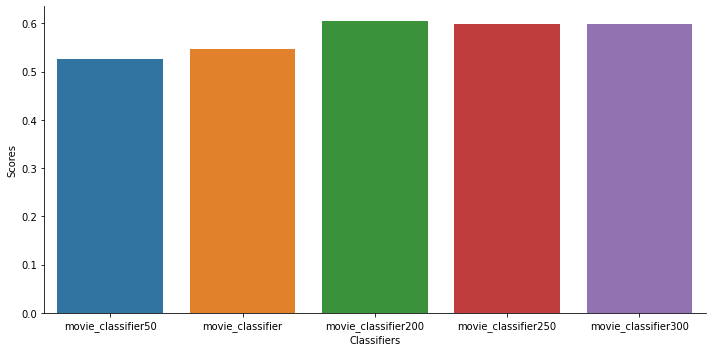

In [24]:
import seaborn as sns

classifiers = ['movie_classifier50', 'movie_classifier', 'movie_classifier200', 'movie_classifier250', 
               'movie_classifier300']
scores = [0.5266666666666666, 0.5466666666666666, 0.605, 0.5983333333333334, 0.5983333333333334]

d = pd.DataFrame({'Classifiers': classifiers, 'Scores': scores})
sns.catplot(x='Classifiers', y='Scores', kind='bar', data=d, aspect=2)

b)

With our updated wordlist classifier, we can see an improved score over the Bayes classifier. I would recommend using a wordlist classifier for similar tasks. The main reason is that the Bayes classifier assumes independence among variables. The occurrence of words in a review are not independent however. In fact, the occurrence of words in most pieces of writing are not independent. Most sentences contain words that can be used together to create sentiment, and hence, combinations of words produce sentiment. The problem with the Bayes classifier is that it assumes individual words create sentiment, rather than the grouping of these words. This is an oversimplistic reduction of the complexity of language. 

In [19]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="NLassignment2021 candidateno 200816.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1283
